# Predicting Phenotype cluster from Genotype for k=2

0/1 classification with logistic regression is a well-studied problem.  In order to familiarize myself with standard logistic regression techniques and begin to work on predicting phenotype clusters from genotype, I will first attempt to predict phenotype clusters with k=2.  This reduces the problem to binary classification.

Author: Rachael Caelie "Rocky" Aikens
 
Created: 0ct 30, 2017
 
Version: 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import random

## Data preprocessing

We have genotype information for siblings from the Agre and Simons Simplex Collection, which has been featurized into a binary matrix (described below). In addition to that, we have ADOS/ADI-R scores for a subset of those individuals, which Kelley Paskov has used to generate soft clusterings of these subjects.

### Feature Data (Genotype)

The input data is represented as a binary matrix.  There are a couple different representations we can use here, but to start I will use 1 = loss of function variant(compound het or homozygous alternate), 0 = no loss of function variant.

In [3]:
# load input feature dataset for Agre
Agre_asd = pd.read_csv("data/v34_lof_asd_af0.50.txt", index_col=0).transpose()
Agre_ctrl = pd.read_csv("data/v34_lof_typical_af0.50.txt", index_col=0).transpose()

print "Cases: ", Agre_asd.shape[0]
print "Controls: ", Agre_ctrl.shape[0]

Cases:  1616
Controls:  349


In [4]:
# load input feature dataset for SSC
SSC_asd = pd.read_csv("data/SSC_lof_asd_af0.50.txt", index_col=0).transpose()
SSC_ctrl = pd.read_csv("data/SSC_lof_typical_af0.50.txt", index_col=0).transpose()

print "Cases: ", SSC_asd.shape[0]
print "Controls: ", SSC_ctrl.shape[0]

Cases:  517
Controls:  518


In [14]:
# merge SSC and Agre data
X_asd = pd.concat([SSC_asd, Agre_asd], axis = 0).fillna(0)
X_ctrl = pd.concat([SSC_ctrl, Agre_ctrl], axis = 0).fillna(0)

In [15]:
X = pd.concat([X_asd, X_ctrl], axis=0)
print "Total cases: ", X_asd.shape[0]
print "Total controls: ", X_ctrl.shape[0]
print "Features (ie. genes): ", X.shape[1]
print "Missing Values: ", int(X.isnull().values.any())

Total cases:  2133
Total controls:  867
Features (ie. genes):  1109
Missing Values:  0


**Note**: In practice, we'll find that most of the 'control' subjects in both Agre and SSC do not have ADOS/ADI-R information or phenotype cluster assignments, which means that they will be excluded from our analysis (see **Filtering for Overlap**)

### Target Data (Phenotype cluster)

We have soft k means cluster membership information for an overlapping set of individuals, for varying values of k.  As mentioned above, we will focus herein on k = 2, since this reduces to a binary classification problem.

In [5]:
# load outcome dataset
Y_soft_2 = pd.read_csv("/scratch/PI/dpwall/DATA/iHART/kpaskov/PhenotypeGLRM/data/softkmeans_logloss_X2.csv", index_col=0, header = None)

#### Getting hard cluster definitions

For softmax regression to work, we need hard rather than soft labels for our dataset. We will turn our soft clustering into a hard one by assigning each subject to the cluster with the highest associated membership value.

In [6]:
Y_2 = Y_soft_2.idxmax(axis = 1)
print Y_2.value_counts()

2    7879
1    5555
dtype: int64


### Filtering for Overlap
Once we import the data, we need to reconstruct X and Y so that they contain the same subjects in the same order.

In [18]:
# get lists of individuals in X and Y
m_x = X.index.values.tolist()
m_x_asd = X_asd.index.tolist()
m_x_ctrl = X_ctrl.index.tolist()
m_y = Y_2.index.values.tolist()

# check subject overlap between X and Y
print "%d subjects in X are not in y.  Of these, %d are cases and %d are controls." % (len(set(m_x) - set(m_y)), len(set(m_x_asd) - set(m_y)), len(set(m_x_ctrl) - set(m_y)))

# make a list of Subject IDs with overlap
subjects = list(set(m_x) & set(m_y))
print "This leaves %d subjects: %d cases and %d controls." % (len(subjects), len(set(m_x_asd) & set(m_y)), len(set(m_x_ctrl)&set(m_y))) 

868 subjects in X are not in y.  Of these, 5 are cases and 863 are controls.
This leaves 2132 subjects: 2128 cases and 4 controls.


**Note:** The set of "cases" and "controls" appear to be differently defined between the iHart Phenotype labels (see `LR_CGT_to_diagnosis.ipynb`) and the CGT matrix labels. 

In [19]:
# redefine X and Y to contain only individuals with genotype and phenotype data
X = X.ix[subjects]
Y_2 = Y_2.ix[subjects]

# check we have the same subject IDs in the same order for X and Y
print Y_2.index.values.tolist() == X.index.values.tolist()

True


## Hold-out Test Set

Since we have ~1,600 examples, I'm going to hold out 20% of the data as a test set and then do 5 fold cross validation using built-in sklearn methods.

In [20]:
random.seed(143)
X_train, X_test, y_train, y_test = train_test_split(X, Y_2, test_size=0.2)

## Logistic Regression

### Model and training parameters

I am going to implement logistic regression using sklearn.

We'll start with the following parameters:

**Cost function**
- Penalty distance metric = $L_2$
- Dual formulation = `False` (better when $m$ > $n$)
- c ($\frac{1}{\lambda}$ for regularization) = 1

**Optimization Algorithm**
- tolerance for convergence = $1\times 10^{-4}$
- optimization algorithm = liblinear

**Model definition**
- fit_intercept = `True`
- class weighting = None
- multi_class = 'ovr'

More or less, these are the sklearn defaults, which I can tune at a later point.

I've built a python object called EvalLR which will help me run cross validation for my regression models and output plots and statistics.  The following code initializes an EvalLR with the logistic regression model described above:

In [ ]:
# Import EvalLR
import class_EvalLR
reload(class_EvalLR)
from class_EvalLR import EvalLR

In [22]:
evalr = EvalLR(X_train, y_train)


Running cross validation for fold 1:
Train Score: 0.710000 Test Score: 0.248276


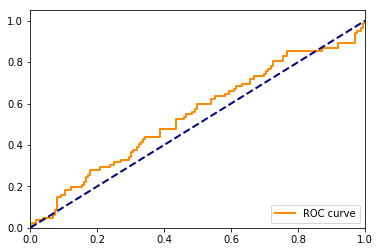


Running cross validation for fold 2:
Train Score: 0.740291 Test Score: 0.331034


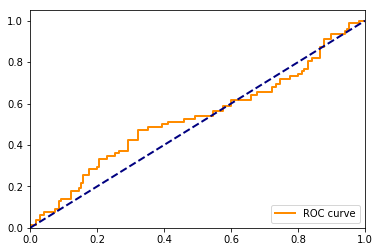


Running cross validation for fold 3:
Train Score: 0.718711 Test Score: 0.295082


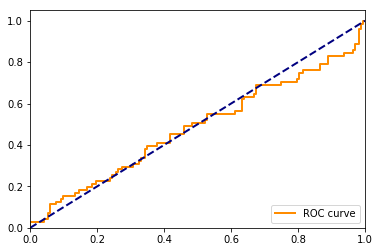


Running cross validation for fold 4:
Train Score: 0.709677 Test Score: 0.337838


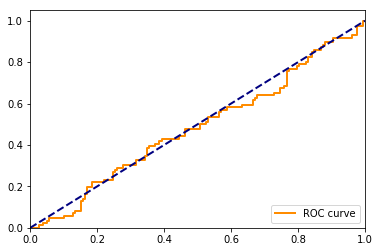


Running cross validation for fold 5:
Train Score: 0.697500 Test Score: 0.304348


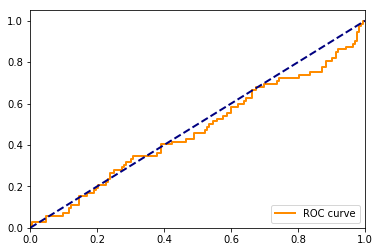


Running cross validation for fold 6:
Train Score: 0.710784 Test Score: 0.306452


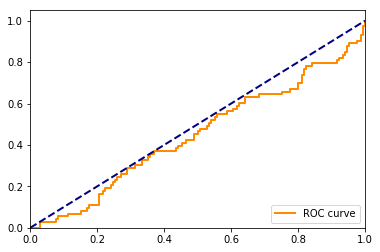


Running cross validation for fold 7:
Train Score: 0.717557 Test Score: 0.344371


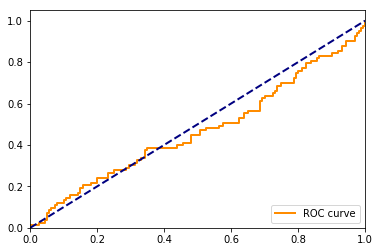

In [23]:
scores, topgenes = evalr.kfold(7, makeROC = True)

In [24]:
print scores
print "Train:", np.mean(scores.Train_score)
print "Test:", np.mean(scores.Test_score)

  Train_score Test_score
1        0.71   0.248276
2    0.740291   0.331034
3    0.718711   0.295082
4    0.709677   0.337838
5      0.6975   0.304348
6    0.710784   0.306452
7    0.717557   0.344371
Train: 0.714931646208
Test: 0.309628635685


## Improvements

- We appear to have a problem with generalization error.  It may help to tinker with other methods (lasso regression), or try adjusting the regulatization parameter.
- need to split train and test data by family ID, like sibkfold